# Style Transfer

This is an attempt to re-implement the paper Style Transfer

Paper: https://arxiv.org/pdf/1508.06576.pdf

Other Resources: 
* https://www.tensorflow.org/tutorials/generative/style_transfer

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image

In [3]:
content_image_path = r'E:\Image Datasets\Style Transfer Images\Content Images\GoldenGate.jpg'
style_image_path = r'E:\Image Datasets\Style Transfer Images\Style Images\starry_night.jpg'
image_size = 512

content_image = np.array(Image.open(content_image_path).resize([image_size, image_size]))
style_image = np.array(Image.open(style_image_path).resize([image_size, image_size]))

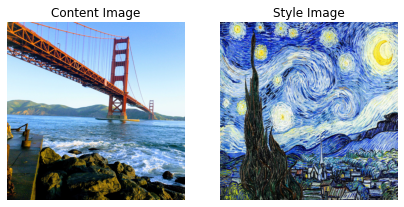

In [9]:
plt.figure(figsize = (7, 7))

plt.subplot(121)
plt.imshow(content_image)
plt.title('Content Image')
plt.axis('off')

plt.subplot(122)
plt.imshow(style_image)
plt.title('Style Image')
plt.axis('off')

plt.show()

In [12]:
vgg_bias = tf.keras.applications.vgg19.preprocess_input(np.zeros(3).astype('float32'))
vgg_bias

array([-103.939, -116.779, -123.68 ], dtype=float32)

In [16]:
preprocess_input = lambda x: tf.keras.applications.vgg19.preprocess_input(np.expand_dims(x, axis = 0))

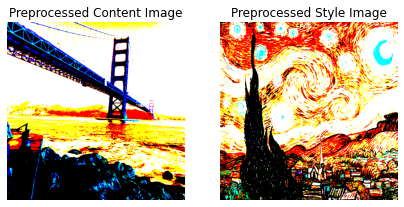

In [21]:
plt.figure(figsize = (7, 7))

plt.subplot(121)
plt.imshow(np.clip(preprocess_input(content_image)[0], 0, 1))
plt.title('Preprocessed Content Image')
plt.axis('off')

plt.subplot(122)
plt.imshow(np.clip(preprocess_input(style_image)[0], 0, 1))
plt.title('Preprocessed Style Image')
plt.axis('off')

plt.show()

In [29]:
def deprocess_input(x):
    x = np.array(x)
    x -= vgg_bias
    
    out = np.concatenate([x[:, :, :, 2].reshape(1, image_size, image_size, 1), 
                          x[:, :, :, 1].reshape(1, image_size, image_size, 1), 
                          x[:, :, :, 0].reshape(1, image_size, image_size, 1)], axis = -1)
    return out

assert (deprocess_input(preprocess_input(content_image))[0].astype('uint8') == content_image).all()
assert (deprocess_input(preprocess_input(style_image))[0].astype('uint8') == style_image).all()

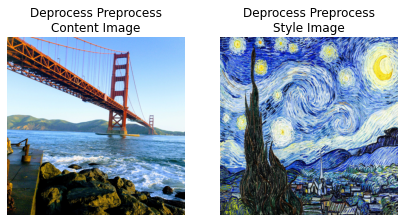

In [25]:
plt.figure(figsize = (7, 7))

plt.subplot(121)
plt.imshow(deprocess_input(preprocess_input(content_image))[0].astype('uint8'))
plt.title('Deprocess Preprocess\nContent Image')
plt.axis('off')

plt.subplot(122)
plt.imshow(deprocess_input(preprocess_input(style_image))[0].astype('uint8'))
plt.title('Deprocess Preprocess\nStyle Image')
plt.axis('off')

plt.show()

In [30]:
CONTENT_LAYERS = ['block5_conv2']
STYLE_LAYERS = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

def build_model():
    vgg_model = tf.keras.applications.VGG19(include_top = False, weights = 'imagenet')
    vgg_model.trainable = False
    
    outs = [vgg_model.get_layer(layer).output for layer in CONTENT_LAYERS + STYLE_LAYERS]
    return tf.keras.models.Model(vgg_model.inputs, outs)

In [32]:
class Loss(object):
    def get_content_loss(self, base_content_layer, base_gen_layer):
        return tf.math.reduce_mean(tf.square(base_content_layer - base_gen_layer))
    
    def get_gram_matrix(self, layer):
        layer = tf.reshape(layer, (-1, layer.shape[-1]))
        grams = tf.matmul(layer, layer, transpose_a = True)
        n = grams.shape[0]
        return grams / tf.cast(n, tf.float32), n
    
    def get_style_loss(self, base_style_layer, base_gen_layer):
        gram_style, n1 = self.get_gram_matrix(base_style_layer)
        gram_gen, n2 = self.get_gram_matrix(base_gen_layer)
        assert n1 == n2
        return tf.math.reduce_mean(tf.square(gram_style - gram_gen)) / (4*(n1**2)*(n2**2))
    
    def get_total_loss(self, base_content_layer, base_style_layer, base_gen_layer, alpha = 0.5):
        # Content Loss
        content_base = base_content_layer[:len(CONTENT_LAYERS)]
        content_gen = base_gen_layer[:len(CONTENT_LAYERS)]
        N1 = len(content_base)
        content_loss = 0
        
        for i in range(N1):
            content_loss += self.get_content_loss(content_base[i], content_gen[i]) / N1
            
        # Style Loss
        style_base = base_style_layer[len(CONTENT_LAYERS):]
        style_gen = base_gen_layer[len(CONTENT_LAYERS):]
        N2 = len(style_base)
        style_loss = 0
        
        for i in range(N2):
            style_loss += self.get_style_loss(style_base[i], style_gen[i])
            
        # Total Loss
        total_loss = ((1 - alpha) * style_loss) + (alpha * content_loss)
        return total_loss


In [33]:
l = Loss()
optimizer = tf.keras.optimizers.Adam(learning_rate = 5, beta_1 = 0.99, epsilon = 1e-3)

In [56]:
# @tf.function
def train(epochs = 501):

    min_val = vgg_bias
    max_val = vgg_bias + 255

    base_model = build_model()

    preprocess_content_image = preprocess_input(content_image)
    preprocess_style_image = preprocess_input(style_image)
    gen_img = tf.Variable(preprocess_content_image + tf.random.normal(preprocess_content_image.shape))

    base_content_layers = base_model(preprocess_content_image)
    base_style_layers = base_model(preprocess_style_image)

    for e in range(epochs):
        loss = 0
        with tf.GradientTape() as tape:
            tape.watch(gen_img)
            base_gen_layers = base_model(gen_img)
            loss = l.get_total_loss(base_content_layers, base_style_layers, base_gen_layers, alpha = 0.5)

        grads = tape.gradient(loss, gen_img)
        optimizer.apply_gradients([(grads, gen_img)])

        clipped = tf.clip_by_value(gen_img, min_val, max_val)
        gen_img.assign(clipped)
        
        if e%100 == 0:
            print(f'Epoch: {e} \t Loss: {loss}')
    return gen_img

In [57]:
gen_img = train()

Epoch: 0 	 Loss: 305027.28125
Epoch: 100 	 Loss: 17001.02734375
Epoch: 200 	 Loss: 6858.5966796875
Epoch: 300 	 Loss: 2441.5791015625
Epoch: 400 	 Loss: 945.00146484375
Epoch: 500 	 Loss: 500.56854248046875


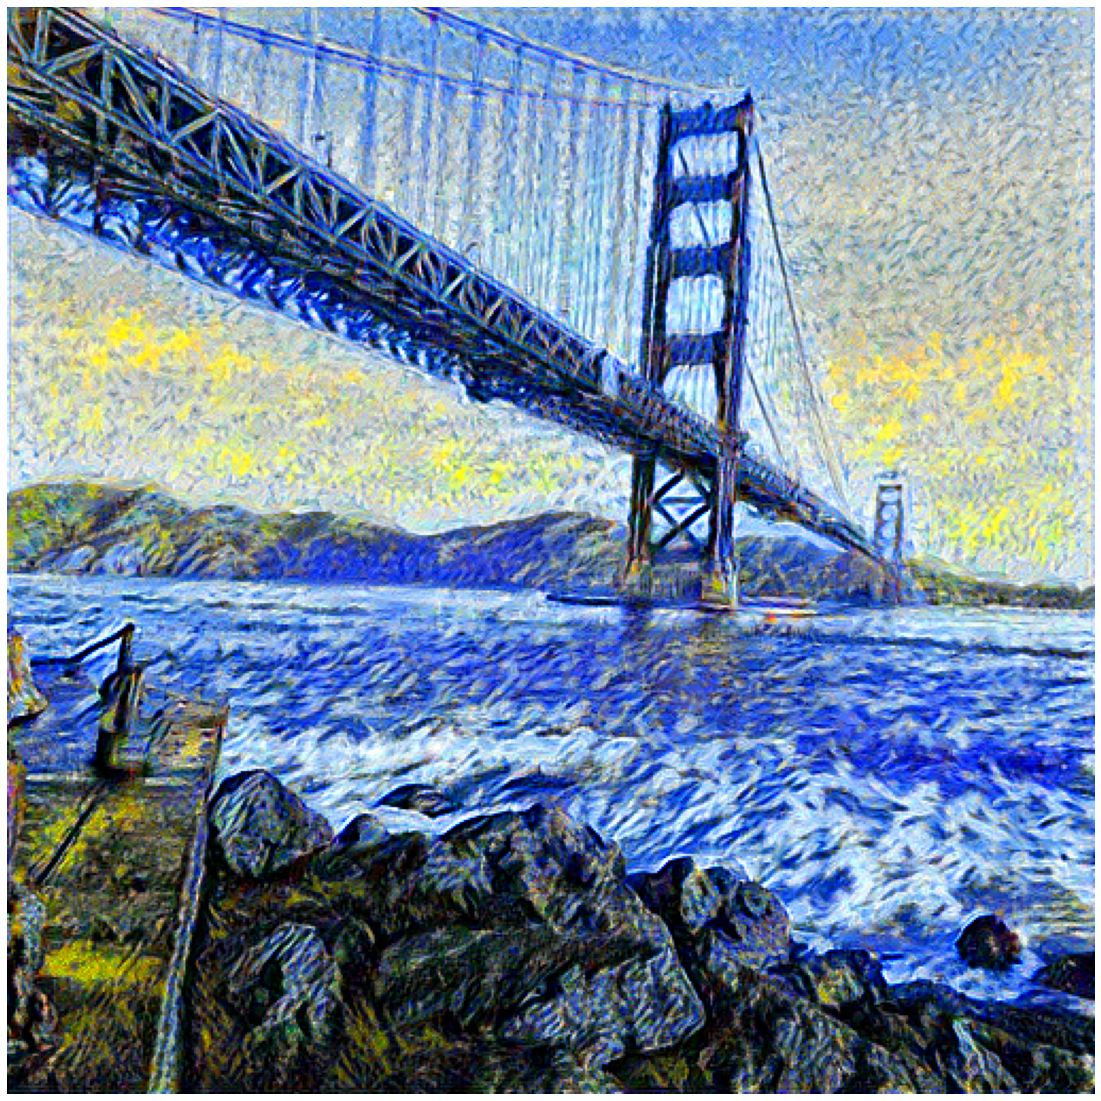

In [58]:
plt.figure(figsize = (20, 20))
plt.imshow(deprocess_input(gen_img)[0].astype('uint8'))
plt.axis('off')
plt.show()